In [1]:
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
)
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import svm, neighbors
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import warnings
import os

output_dir = "USDA-NASS--v01/OUTPUTS/"
archive_dir = "ML-ARCHIVES--v01/"
tif_dir = "GAEZ-SOIL-for-ML/OUTPUTS/"
out_dir = archive_dir + "WEATHER-DATA--v01/"
weather_dir = archive_dir + "WEATHER-DATA--v01/"
ml_tables_dir = archive_dir + "ML-TABLES--v01/"


In [2]:
def plot_predictions(y_test, y_pred, descrip_of_run):
    # Check if the arrays have the same length
    if len(y_test) != len(y_pred):
        raise ValueError("The input arrays must have the same length.")

    # Create a scatter plot
    plt.scatter(y_test, y_pred)
    plt.plot(y_test, y_test, color="red", linestyle="--")  # Line y_pred = y_test
    plt.xlabel("y_test")
    plt.ylabel("y_pred")
    plt.title("Predicted vs Actual for " + descrip_of_run)
    plt.grid(True)
    t = "Predicted vs Actual for " + descrip_of_run
    t = t.replace(" ", "_")
    os.makedirs("images", exist_ok=True)
    plt.savefig("images/" + t + ".png")
    plt.show()

def relative_root_mean_squared_error(true, pred):
    num = np.sum(np.square(true - pred))
    den = np.sum(np.square(pred))
    squared_error = num/den
    rrmse_loss = np.sqrt(squared_error)
    return rrmse_loss

In [3]:
def plot_rfe(rfecv, min_features_to_select, title):
    n_scores = len(rfecv.cv_results_["mean_test_score"])
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean test accuracy")
    plt.errorbar(
        range(min_features_to_select, n_scores + min_features_to_select),
        rfecv.cv_results_["mean_test_score"],
        yerr=rfecv.cv_results_["std_test_score"],
    )
    plt.title("Recursive Feature Elimination \nwith correlated features")
    os.makedirs("images", exist_ok=True)
    plt.savefig("images/" + title + "_features" + ".png")
    plt.show()

def test_model(X_train, y_train, X_test, y_test, min_features_to_select, title, ravel=False, model=LinearRegression()):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        min_features_to_select = min_features_to_select
        clf = model

        if type(model).__name__ == "HalvingGridSearchCV":
            importance_getter = "best_estimator_.feature_importances_"
        else:
            importance_getter = "auto"

        rfecv = RFECV(
            estimator=clf,
            step=1,
            cv=5,
            scoring='r2',
            min_features_to_select=min_features_to_select,
            importance_getter=importance_getter,
        )
        if ravel:
            y_train = y_train.ravel()
        rfecv.fit(X_train, y_train)

        print(f"Optimal number of features: {rfecv.n_features_}")

        y_pred = rfecv.predict(X_test)

        if ravel:
            rrmse = relative_root_mean_squared_error(y_test.ravel(), y_pred)
        else:
            rrmse = relative_root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"RRMSE: {rrmse}")
        print(f"R-squared: {r2}")

        plot_rfe(rfecv, min_features_to_select, title)
        plot_predictions(y_test, y_pred, title)

## Load ML files

In [4]:
ml_file = "ML-table-weekly.csv"

df_ml = pd.read_csv(ml_tables_dir + ml_file)
print(df_ml.shape)
df_ml


(10015, 217)


,year,state_name,county_name,yield,nutr_ret_high,suit_irrig_high_soy,13,AEZ_1,AEZ_2,AEZ_3,...,week_29__PRECTOTCORR,week_29__GWETROOT,week_29__EVPTRNS,week_29__ALLSKY_SFC_PAR_TOT,week_30__T2M_MAX,week_30__T2M_MIN,week_30__PRECTOTCORR,week_30__GWETROOT,week_30__EVPTRNS,week_30__ALLSKY_SFC_PAR_TOT
0,2022,COLORADO,LARIMER,191.1,10,-1,True,False,False,False,...,3.57,0.392857,0.032857,549.97,5.844286,-6.111429,8.58,0.394286,0.012857,418.83
1,2020,COLORADO,LARIMER,128.2,10,-1,True,False,False,False,...,19.87,0.350000,0.001429,395.03,4.646667,-9.695000,2.85,0.370000,0.003333,376.31
2,2019,COLORADO,LARIMER,148.5,10,-1,True,False,False,False,...,20.15,0.387143,0.007143,387.67,-6.130000,-16.562500,10.84,0.400000,0.000000,209.51
3,2016,COLORADO,LARIMER,101.2,10,-1,True,False,False,False,...,6.12,0.380000,0.015714,481.31,15.797143,2.874286,2.79,0.378571,0.012857,363.08
4,2015,COLORADO,LARIMER,130.0,10,-1,True,False,False,False,...,31.08,0.408571,0.015714,346.47,7.685000,-3.086667,10.13,0.430000,0.028333,325.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,2007,OHIO,WASHINGTON,125.1,9,10000,False,False,False,True,...,10.28,0.434286,0.078571,406.63,17.492857,9.127143,49.90,0.487143,0.122857,256.20
10011,2006,OHIO,WASHINGTON,150.3,9,10000,False,False,False,True,...,52.32,0.587143,0.328571,254.67,9.240000,0.950000,30.17,0.601429,0.230000,290.33
10012,2005,OHIO,WASHINGTON,100.8,9,10000,False,False,False,True,...,30.31,0.484286,0.145714,347.48,10.154286,0.445714,39.13,0.554286,0.194286,314.19
10013,2004,OHIO,WASHINGTON,138.0,9,10000,False,False,False,True,...,48.96,0.630000,0.362857,252.24,20.260000,9.424286,12.99,0.632857,0.542857,331.08


## Remove rows that have null values

In [5]:
has_null = np.array([np.sum(x) for x in df_ml.isnull().values])

In [6]:
df_ml = df_ml[np.where(has_null > 0, False, True)]

In [7]:
df_ml.shape

(10015, 217)

In [8]:
df_ml["year_trend"] = df_ml["year"] - df_ml["year"].min()

|date	|week|	|
|--		|--	|--	|
|1-Apr	| 0 |	|
|8-Apr	| 1 |	|
|15-Apr	| 2 |	|
|22-Apr	| 3 |	|
|29-Apr	| 4 |	|
|6-May	| 5 |	|
|13-May	| 6 |	|
|20-May	| 7 |	|
|27-May	| 8 |	|
|3-Jun	| 9 | first planting	|
|10-Jun	| 10 |	|
|17-Jun	| 11 |	|
|24-Jun	| 12 |	|
|1-Jul	| 13 |	|
|8-Jul	| 14 |	|
|15-Jul	| 15 |	|
|22-Jul	| 16 |	|
|29-Jul	| 17 |	|
|5-Aug	| 18 |	|
|12-Aug	| 19 |	|
|19-Aug	| 20 |	|
|26-Aug	| 21 |	|
|2-Sep	| 22 |harvest	|
|9-Sep	| 23 |	|
|16-Sep	| 24 |	|
|23-Sep	| 25 |	|
|30-Sep	| 26 |	|
|7-Oct	| 27 |	|
|14-Oct	| 28 |	|
|21-Oct	| 29 |	|
|28-Oct	| 30 |	|
|4-Nov	| 31 |	|

In [9]:
long_window_weeks = ["09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22"]
short_window_weeks = ["17", "18", "19", "20", "21", "22"]

all_weeks = ["00", "01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30", "31"]

long_window_exclude = [x for x in all_weeks if x not in long_window_weeks]
short_window_exclude = [x for x in all_weeks if x not in short_window_weeks]

In [10]:
long_window_columns = [x for x in df_ml.columns if not any(s in x for s in long_window_exclude)]
short_window_columns = [x for x in df_ml.columns if not any(s in x for s in short_window_exclude)]

long_ml = df_ml[long_window_columns]
short_ml = df_ml[short_window_columns]

In [11]:
long_ml

,year,state_name,county_name,yield,nutr_ret_high,suit_irrig_high_soy,13,AEZ_1,AEZ_2,AEZ_3,...,week_21__GWETROOT,week_21__EVPTRNS,week_21__ALLSKY_SFC_PAR_TOT,week_22__T2M_MAX,week_22__T2M_MIN,week_22__PRECTOTCORR,week_22__GWETROOT,week_22__EVPTRNS,week_22__ALLSKY_SFC_PAR_TOT,year_trend
0,2022,COLORADO,LARIMER,191.1,10,-1,True,False,False,False,...,0.425714,0.172857,734.18,27.215714,7.511429,1.47,0.412857,0.178571,833.77,19
1,2020,COLORADO,LARIMER,128.2,10,-1,True,False,False,False,...,0.352857,0.011429,596.50,25.935714,6.171429,2.25,0.352857,0.010000,828.21,17
2,2019,COLORADO,LARIMER,148.5,10,-1,True,False,False,False,...,0.398571,0.104286,822.90,25.197143,9.180000,18.31,0.391429,0.065714,687.67,16
3,2016,COLORADO,LARIMER,101.2,10,-1,True,False,False,False,...,0.380000,0.035714,641.63,21.547143,7.480000,7.59,0.380000,0.030000,677.68,13
4,2015,COLORADO,LARIMER,130.0,10,-1,True,False,False,False,...,0.407143,0.091429,698.97,22.144286,8.112857,8.79,0.402857,0.072857,603.37,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,2007,OHIO,WASHINGTON,125.1,9,10000,False,False,False,True,...,0.524286,1.231429,663.05,31.131429,15.367143,1.58,0.488571,0.985714,774.40,4
10011,2006,OHIO,WASHINGTON,150.3,9,10000,False,False,False,True,...,0.415714,0.125714,748.72,24.562857,16.007143,30.79,0.450000,0.137143,347.36,3
10012,2005,OHIO,WASHINGTON,100.8,9,10000,False,False,False,True,...,0.441429,0.238571,637.60,26.412857,16.014286,43.33,0.498571,0.791429,582.26,2
10013,2004,OHIO,WASHINGTON,138.0,9,10000,False,False,False,True,...,0.514286,1.207143,675.52,28.827143,15.462857,4.25,0.501429,1.032857,675.33,1


## Separate into features and labels

In [12]:
short_X = short_ml.drop(columns=["yield"])
short_y = short_ml.loc[:, ["yield"]]

short_X_train, short_X_test, short_y_train, short_y_test = train_test_split(short_X, short_y, test_size=0.2, random_state=0)

In [13]:
long_X = long_ml.drop(columns=["yield"])
long_y = long_ml.loc[:, ["yield"]]

long_X_train, long_X_test, long_y_train, long_y_test = train_test_split(long_X, long_y, test_size=0.2, random_state=0)

In [14]:
long_X_train.shape

(8012, 115)

In [15]:
long_X_test.shape

(2003, 115)

## Standard Scaler transformation

In [16]:
long_X_train = long_X_train.drop(columns=["year", "state_name", "county_name"])
long_X_test = long_X_test.drop(columns=["year", "state_name", "county_name"])


long_scalerXST = StandardScaler().fit(long_X_train)
long_scaleryST = StandardScaler().fit(long_y_train)

long_X_trainST = long_scalerXST.transform(long_X_train)
long_X_testST = long_scalerXST.transform(long_X_test)

In [17]:
short_X_train = short_X_train.drop(columns=["year", "state_name", "county_name"])
short_X_test = short_X_test.drop(columns=["year", "state_name", "county_name"])


short_scalerXST = StandardScaler().fit(short_X_train)
short_scaleryST = StandardScaler().fit(short_y_train)

short_X_trainST = short_scalerXST.transform(short_X_train)
short_X_testST = short_scalerXST.transform(short_X_test)

In [18]:
long_y_trainNP = long_y_train.to_numpy()
long_y_testNP = long_y_test.to_numpy()

In [19]:
short_y_trainNP = short_y_train.to_numpy()
short_y_testNP = short_y_test.to_numpy()

## Train lasso model

In [20]:
lassoST = Lasso(alpha=0.1)
lassoST.fit(long_X_trainST, long_y_trainNP)

y_predST = lassoST.predict(long_X_testST)

In [21]:
rmseST = relative_root_mean_squared_error(long_y_testNP, y_predST)

print(rmseST)

10.594207689716596


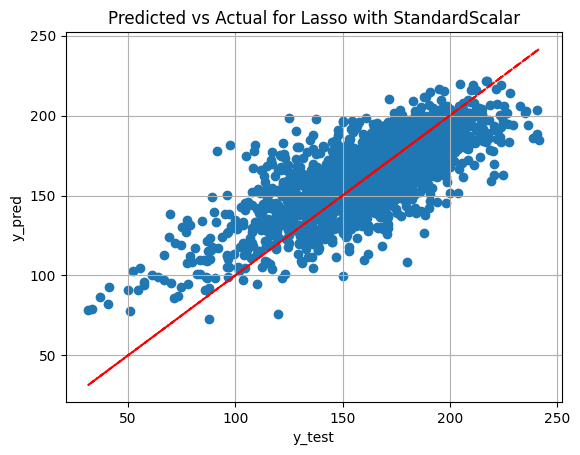

In [22]:
plot_predictions(long_y_testNP, y_predST, "Lasso with StandardScalar")

## Train linear regression model

0.5790931766406341
0.1214027261194665


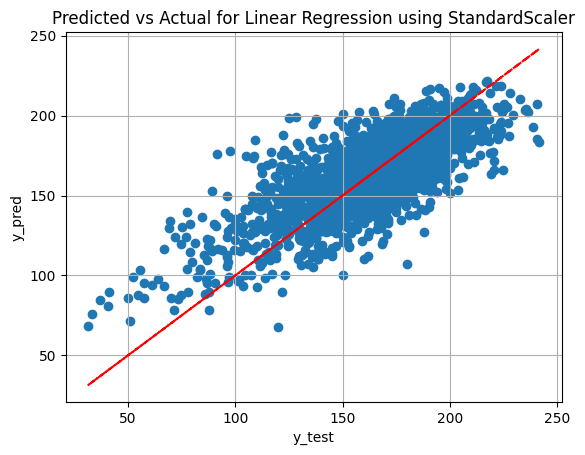

In [23]:
linearST = LinearRegression()
linearST.fit(long_X_trainST, long_y_trainNP)

y_predLR = linearST.predict(long_X_testST)

r2LR = r2_score(long_y_testNP, y_predLR)
print(r2LR)
print(relative_root_mean_squared_error(long_y_testNP, y_predLR))

plot_predictions(long_y_testNP, y_predLR, "Linear Regression using StandardScaler")

0.48814447866693955
0.13430943076192875


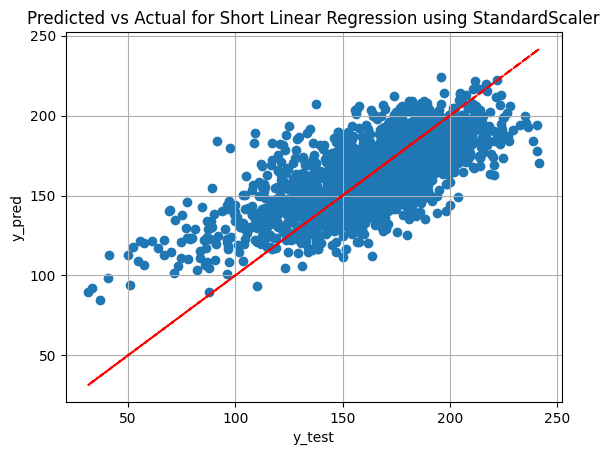

In [24]:
linearST = LinearRegression()
linearST.fit(short_X_trainST, short_y_trainNP)

y_predLR = linearST.predict(short_X_testST)

r2LR = r2_score(short_y_testNP, y_predLR)
print(r2LR)
print(relative_root_mean_squared_error(short_y_testNP, y_predLR))

plot_predictions(short_y_testNP, y_predLR, "Short Linear Regression using StandardScaler")

# No hyperparameter tuning. Go straight to RFE

Optimal number of features: 105
RRMSE: 0.12166257522145173
R-squared: 0.577332746413188


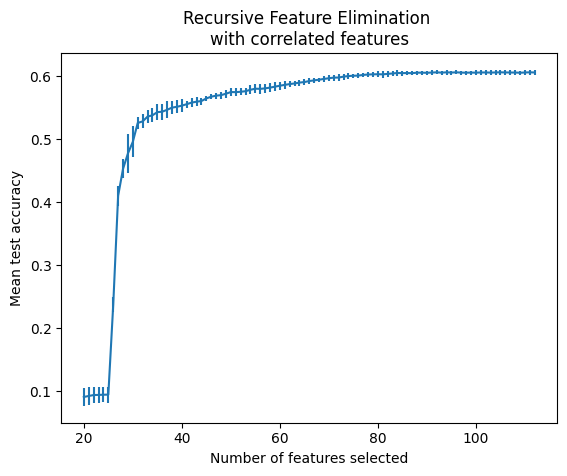

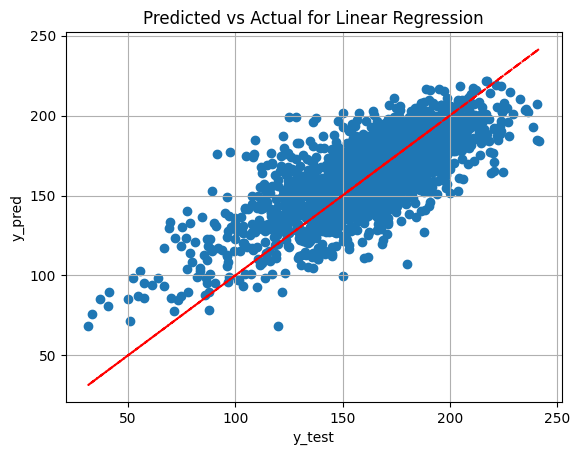

In [25]:
test_model(long_X_trainST, long_y_trainNP, long_X_testST, long_y_testNP, 20, "Linear Regression", model=LinearRegression())

Optimal number of features: 63
RRMSE: 0.13430943076192875
R-squared: 0.48814447866693955


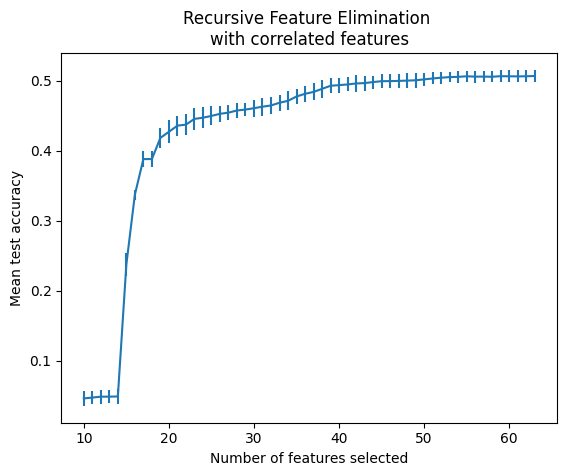

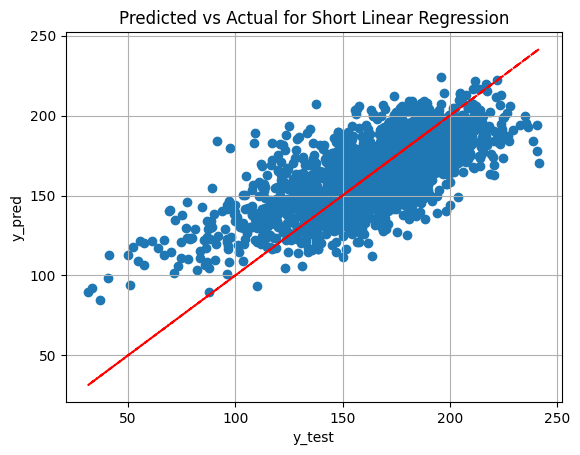

In [26]:
test_model(short_X_trainST, short_y_trainNP, short_X_testST, short_y_testNP, 10, "Short Linear Regression", model=LinearRegression())

# Random Forrest

0.08825862734458287
0.7769525657159779


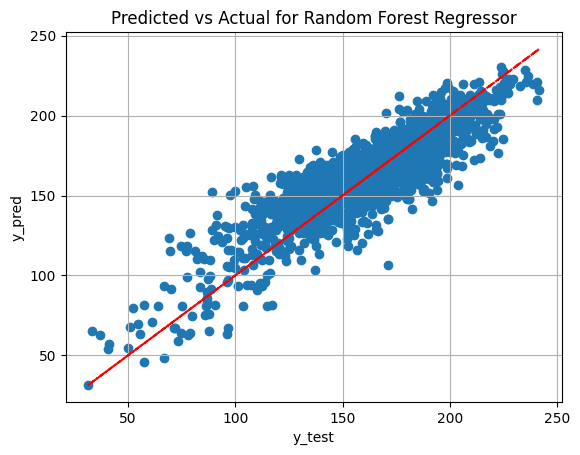

In [27]:
regrRF = RandomForestRegressor()

regrRF.fit(long_X_trainST, long_y_trainNP.ravel())

y_predRF = regrRF.predict(long_X_testST)
rmseRF = relative_root_mean_squared_error(long_y_testNP.ravel(), y_predRF)
r2RF = r2_score(long_y_testNP, y_predRF)
print(rmseRF)
print(r2RF)

plot_predictions(long_y_testNP, y_predRF, "Random Forest Regressor")

0.09088260926458377
0.7631035705667008


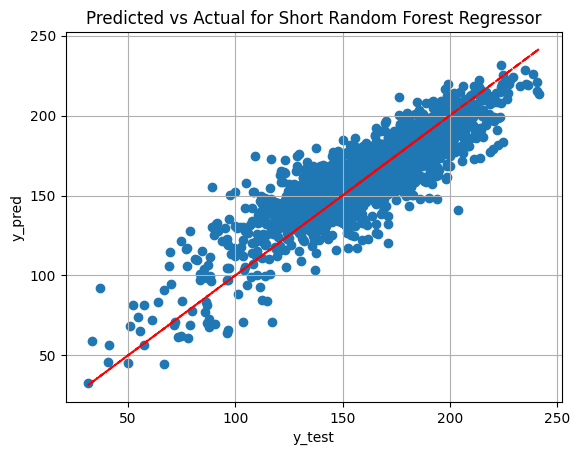

In [28]:
regrRF = RandomForestRegressor()

regrRF.fit(short_X_trainST, short_y_trainNP.ravel())

y_predRF = regrRF.predict(short_X_testST)
rmseRF = relative_root_mean_squared_error(short_y_testNP.ravel(), y_predRF)
r2RF = r2_score(short_y_testNP, y_predRF)
print(rmseRF)
print(r2RF)

plot_predictions(short_y_testNP, y_predRF, "Short Random Forest Regressor")

# SVM

0.11736527254954367
0.6026178266360145


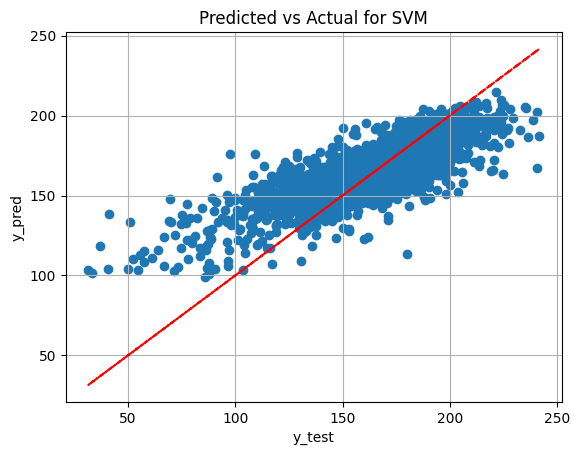

In [29]:
regrSVM = svm.SVR()
regrSVM.fit(long_X_trainST, long_y_trainNP.ravel())

y_predSVM = regrSVM.predict(long_X_testST)

rmseSVM = relative_root_mean_squared_error(long_y_testNP.ravel(), y_predSVM)
print(rmseSVM)
r2SVM = r2_score(long_y_testNP, y_predSVM)
print(r2SVM)

plot_predictions(long_y_testNP, y_predSVM, "SVM")

0.12961745262385496
0.5139529360458923


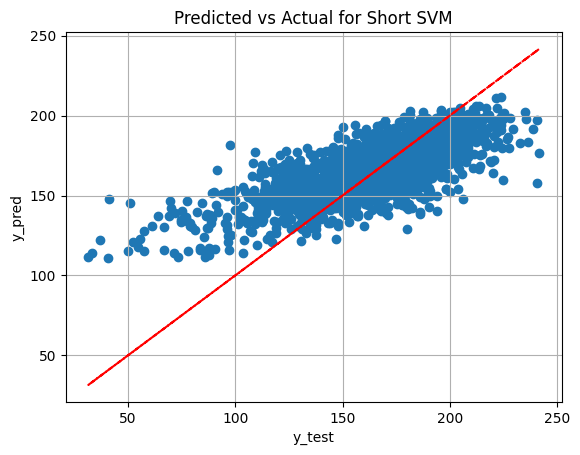

In [30]:
regrSVM = svm.SVR()
regrSVM.fit(short_X_trainST, short_y_trainNP.ravel())

y_predSVM = regrSVM.predict(short_X_testST)

rmseSVM = relative_root_mean_squared_error(short_y_testNP.ravel(), y_predSVM)
print(rmseSVM)
r2SVM = r2_score(short_y_testNP, y_predSVM)
print(r2SVM)

plot_predictions(short_y_testNP, y_predSVM, "Short SVM")

# Gradient Boosting

0.1054994513340932
0.6835482070211731


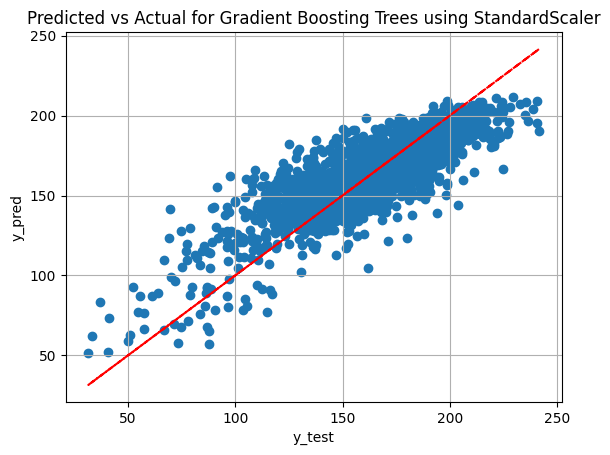

In [31]:
regrGBT = GradientBoostingRegressor()
regrGBT.fit(long_X_trainST, long_y_trainNP.ravel())

y_predGBT = regrGBT.predict(long_X_testST)

rmseGBT = relative_root_mean_squared_error(long_y_testNP.ravel(), y_predGBT)
print(rmseGBT)
r2GBT = r2_score(long_y_testNP, y_predGBT)
print(r2GBT)

plot_predictions(long_y_testNP, y_predGBT, "Gradient Boosting Trees using StandardScaler")

0.11231624520624436
0.641623295377147


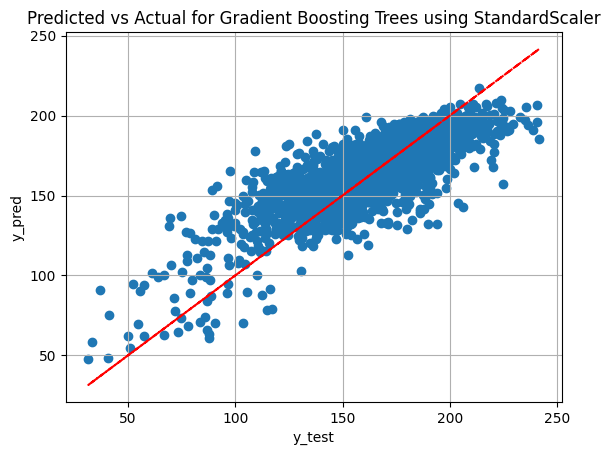

In [32]:
regrGBT = GradientBoostingRegressor()
regrGBT.fit(short_X_trainST, short_y_trainNP.ravel())

y_predGBT = regrGBT.predict(short_X_testST)

rmseGBT = relative_root_mean_squared_error(short_y_testNP.ravel(), y_predGBT)
print(rmseGBT)
r2GBT = r2_score(short_y_testNP, y_predGBT)
print(r2GBT)

plot_predictions(short_y_testNP, y_predGBT, "Gradient Boosting Trees using StandardScaler")

# AdaBoost

0.13412511548915057
0.5136061660786801


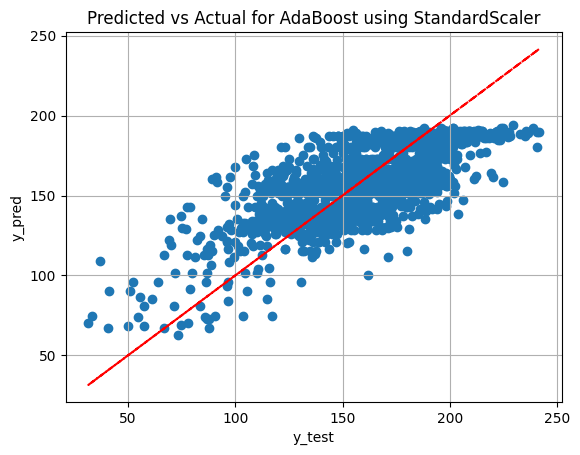

In [33]:
regrAda = AdaBoostRegressor()
regrAda.fit(long_X_trainST, long_y_trainNP.ravel())

y_predAda = regrAda.predict(long_X_testST)

rmseAda = relative_root_mean_squared_error(long_y_testNP.ravel(), y_predAda)
print(rmseAda)
r2Ada = r2_score(long_y_testNP, y_predAda)
print(r2Ada)

plot_predictions(long_y_testNP, y_predAda, "AdaBoost using StandardScaler")

0.14150697189235972
0.4641469516451029


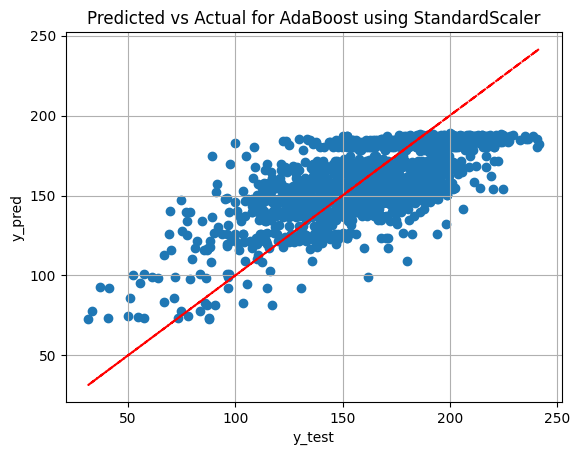

In [34]:
regrAda = AdaBoostRegressor()
regrAda.fit(short_X_trainST, short_y_trainNP.ravel())

y_predAda = regrAda.predict(short_X_testST)

rmseAda = relative_root_mean_squared_error(short_y_testNP.ravel(), y_predAda)
print(rmseAda)
r2Ada = r2_score(short_y_testNP, y_predAda)
print(r2Ada)

plot_predictions(short_y_testNP, y_predAda, "AdaBoost using StandardScaler")

# RFE

In [ ]:
n_estimators = [10, 100]
max_depth = [3, 5, 10]
min_samples_split = [2, 5, 10]
param_grid = {
    "max_depth": max_depth, 
    "min_samples_split": min_samples_split, 
    "n_estimators": n_estimators
}

regrRF = RandomForestRegressor()

gsh = HalvingGridSearchCV(
    estimator=regrRF, param_grid=param_grid, cv=5
)
gsh.fit(long_X_trainST, long_y_trainNP.ravel())

y_predRFGS = gsh.predict(long_X_testST)
rmseRFGS = relative_root_mean_squared_error(long_y_testNP.ravel(), y_predRFGS)
r2RFGS = r2_score(long_y_testNP, y_predRFGS)
print(rmseRFGS)
print(r2RFGS)

test_model(long_X_trainST, long_y_trainNP, long_X_testST, long_y_testNP, 10, "Random Forrest", True, model=gsh.best_estimator_)

In [ ]:
n_estimators = [10, 100]
max_depth = [3, 5, 10]
min_samples_split = [2, 5, 10]
param_grid = {
    "max_depth": max_depth, 
    "min_samples_split": min_samples_split, 
    "n_estimators": n_estimators
}

regrRF = RandomForestRegressor()

gsh = HalvingGridSearchCV(
    estimator=regrRF, param_grid=param_grid, cv=5
)
gsh.fit(short_X_trainST, short_y_trainNP.ravel())

y_predRFGS = gsh.predict(short_X_testST)
rmseRFGS = relative_root_mean_squared_error(short_y_testNP.ravel(), y_predRFGS)
r2RFGS = r2_score(short_y_testNP, y_predRFGS)
print(rmseRFGS)
print(r2RFGS)

test_model(short_X_trainST, short_y_trainNP, short_X_testST, short_y_testNP, 10, "Short Random Forrest", True, model=gsh.best_estimator_)

In [ ]:
param_grid = {'kernel': ('linear', 'rbf'), 'C': [1, 10, 100]}

regrSVM = svm.SVR()

gshSVM = HalvingGridSearchCV(
    estimator=regrSVM, param_grid=param_grid, cv=5
)
gshSVM.fit(long_X_trainST, long_y_trainNP.ravel())

y_predSVMGS = gshSVM.predict(long_X_testST)
rmseSVMGS = relative_root_mean_squared_error(long_y_testNP.ravel(), y_predSVMGS)
r2SVMGS = r2_score(long_y_testNP, y_predSVMGS)
print(rmseSVMGS)
print(r2SVMGS)

plot_predictions(long_y_testNP, y_predSVMGS, "SVM")

In [ ]:
param_grid = {'kernel': ('linear', 'rbf'), 'C': [1, 10, 100]}

regrSVM = svm.SVR()

gshSVM = HalvingGridSearchCV(
    estimator=regrSVM, param_grid=param_grid, cv=5
)
gshSVM.fit(short_X_trainST, short_y_trainNP.ravel())

y_predSVMGS = gshSVM.predict(short_X_testST)
rmseSVMGS = relative_root_mean_squared_error(short_y_testNP.ravel(), y_predSVMGS)
r2SVMGS = r2_score(short_y_testNP, y_predSVMGS)
print(rmseSVMGS)
print(r2SVMGS)

plot_predictions(long_y_testNP, y_predSVMGS, "Short SVM")

In [ ]:
param_grid = {
    "n_estimators": [10, 50, 100, 500],
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],
    "max_depth": [3, 7, 9]
}
regrGBT = GradientBoostingRegressor()

gshGBT = HalvingGridSearchCV(
    estimator=regrGBT, param_grid=param_grid, cv=5
)
gshGBT.fit(long_X_trainST, long_y_trainNP.ravel())

y_predGBTGS = gshGBT.predict(long_X_testST)
rmseGBTGS = relative_root_mean_squared_error(long_y_testNP.ravel(), y_predGBTGS)
r2GBTGS = r2_score(long_y_testNP, y_predGBTGS)
print(rmseGBTGS)
print(r2GBTGS)

test_model(long_X_trainST, long_y_trainNP, long_X_testST, long_y_testNP, 20, "GBT", True, model=gshGBT.best_estimator_)


In [ ]:
param_grid = {
    "n_estimators": [10, 50, 100, 500],
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0],
    "max_depth": [3, 7, 9]
}
regrGBT = GradientBoostingRegressor()

gshGBT = HalvingGridSearchCV(
    estimator=regrGBT, param_grid=param_grid, cv=5
)
gshGBT.fit(short_X_trainST, short_y_trainNP.ravel())

y_predGBTGS = gshGBT.predict(short_X_testST)
rmseGBTGS = relative_root_mean_squared_error(short_y_testNP.ravel(), y_predGBTGS)
r2GBTGS = r2_score(short_y_testNP, y_predGBTGS)
print(rmseGBTGS)
print(r2GBTGS)

test_model(short_X_trainST, short_y_trainNP, short_X_testST, short_y_testNP, 20, "Short GBT", True, model=gshGBT.best_estimator_)


In [ ]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "n_estimators": [1, 2]
}

regrAda = AdaBoostRegressor()

gshAda = HalvingGridSearchCV(
    estimator=regrAda, param_grid=param_grid, cv=5
)
gshAda.fit(long_X_trainST, long_y_trainNP.ravel())

y_predAdaGS = gshAda.predict(long_X_testST)
rmseAdaGS = relative_root_mean_squared_error(long_y_testNP.ravel(), y_predAdaGS)
r2AdaGS = r2_score(long_y_testNP, y_predAdaGS)
print(rmseAdaGS)
print(r2AdaGS)

test_model(long_X_trainST, long_y_trainNP, long_X_testST, long_y_testNP, 20, "Ada", True, model=gshAda.best_estimator_)


In [ ]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "n_estimators": [1, 2]
}

regrAda = AdaBoostRegressor()

gshAda = HalvingGridSearchCV(
    estimator=regrAda, param_grid=param_grid, cv=5
)
gshAda.fit(short_X_trainST, short_y_trainNP.ravel())

y_predAdaGS = gshAda.predict(short_X_testST)
rmseAdaGS = relative_root_mean_squared_error(short_y_testNP.ravel(), y_predAdaGS)
r2AdaGS = r2_score(short_y_testNP, y_predAdaGS)
print(rmseAdaGS)
print(r2AdaGS)

test_model(short_X_trainST, short_y_trainNP, short_X_testST, short_y_testNP, 20, "Short Ada", True, model=gshAda.best_estimator_)